In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline 

from unetgan import *


%load_ext autoreload
%autoreload 2

## Normal setup

In [2]:
import random
import numpy as np
import torchvision

# Maybe add some global variables here for your config
device = torch.device('cuda')

def seed_generators(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
seed_generators(796)

Files already downloaded and verified


## Load pretrained models

In [3]:
dis = models.dcgan.DCGANDiscriminatorV2().to(device)
dis.load_state_dict(torch.load('./unetgan/models/dcgan_d_128x128.pth'))
dis

DCGANDiscriminatorV2(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1024, ker

In [4]:
gen = models.dcgan.DCGANGeneratorV2(nz=120).to(device)
gen.load_state_dict(torch.load('./unetgan/models/dcgan_g_128x128.pth'))
gen

DCGANGeneratorV2(
  (main): Sequential(
    (0): ConvTranspose2d(120, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13):

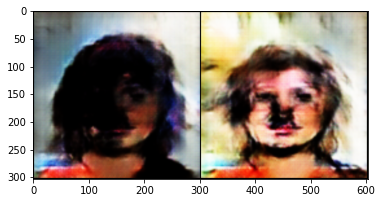

In [17]:
noise = torch.randn((2, 120), device=device)
preview_samples(plt, torchvision.transforms.Resize((299, 299))(gen(noise)))

In [22]:
train_data

Dataset CelebA
    Number of datapoints: 162770
    Root location: .
    Target type: ['attr']
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

## Creating a Fake Dataset

In [63]:
utils.create_sample_directory(gen, sample_dir='./celeba_fake_samples',
                              num_samples=10000, device=device, overwrite=False)

100%|██████████| 10000/10000 [00:53<00:00, 188.16it/s]


We can also subsample the 160k examples of the `CelebA` dataset as well:

In [13]:
utils.create_celeba_sample_directory(celeba_root_dir='.',
                                     sample_dir='./celeba10k_128x128',
                                     num_samples=10000,
                                     overwrite=True)

100%|██████████| 10000/10000 [01:10<00:00, 142.34it/s]


## Computing FID

"Unofficial" PyTorch version of the FID score. Remember, you need `pytorch_fid` for this!

In [14]:
!python -m pytorch_fid ./celeba_fake_samples ./celeba10k_128x128

100%|█████████████████████████████████████████| 200/200 [00:24<00:00,  8.10it/s]
FID:  155.87867566077875


There's also the official (TensorFlow) version, which we can evaluate here. To use it, you need to clone the [official repository](https://github.com/bioinf-jku/TTUR) under this directory, as well as the requirements `tensorflow < 2.0` and `imageio`.
Note: It is really slow, and you may quickly run out of memory depending on the size of the datasets!

In [19]:
!TTUR/fid.py ./celeba_fake_samples ./celeba10k_128x128

2021-05-29 22:21:29.059629: W tensorflow/core/framework/op_def_util.cc:357] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().

2021-05-29 22:21:29.164141: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-05-29 22:21:29.189983: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2021-05-29 22:21:29.190471: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ec81bebc10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-05-29 22:21:29.190510: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info 

(That took around 25 minutes, while the other one took less than a minute)

Finally, we can also compute the FID against the entire CelebA dataset by using the pre-computed datasets statistics. Unfortunately the statistics are computed for 64x64 cropped samples, so it would've been better if the images were the same size.

In [20]:
!python -m pytorch_fid ./celeba_fake_samples ./resources/fid_stats_celeba.npz

100%|█████████████████████████████████████████| 200/200 [00:24<00:00,  8.01it/s]
FID:  225.26907529420458


In [21]:
!TTUR/fid.py ./celeba_fake_samples ./resources/fid_stats_celeba.npz

2021-05-29 22:45:47.586528: W tensorflow/core/framework/op_def_util.cc:357] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().

2021-05-29 22:45:47.701864: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-05-29 22:45:47.730032: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2021-05-29 22:45:47.730676: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56526d761fd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-05-29 22:45:47.730761: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info 